CD converged after 988 iterations
SGD converged after 57 iterations

Coordinate Descent Results:
Accuracy: 0.9737, Precision: 0.9545, Recall: 0.9767, F1: 0.9655

SGD Results:
Accuracy: 0.9649, Precision: 0.9333, Recall: 0.9767, F1: 0.9545

SVM Results:
Accuracy: 0.9825, Precision: 1.0000, Recall: 0.9535, F1: 0.9762


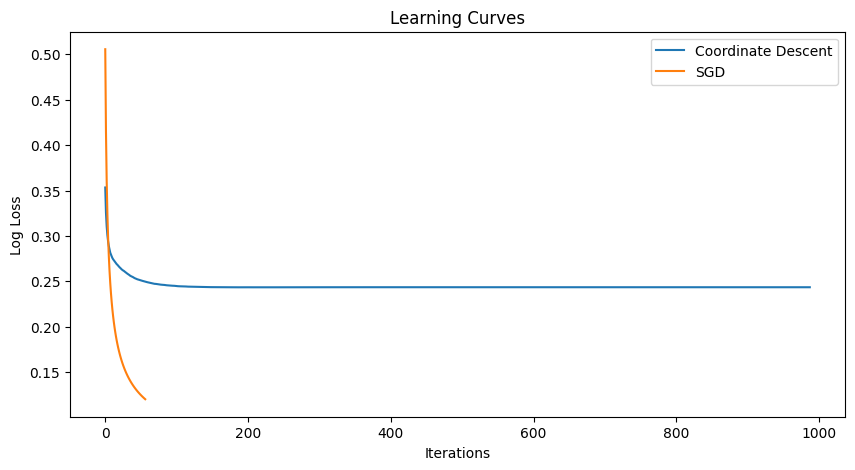

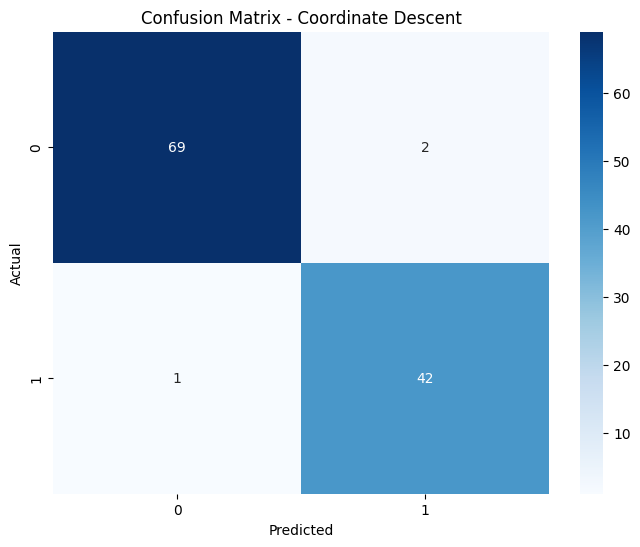

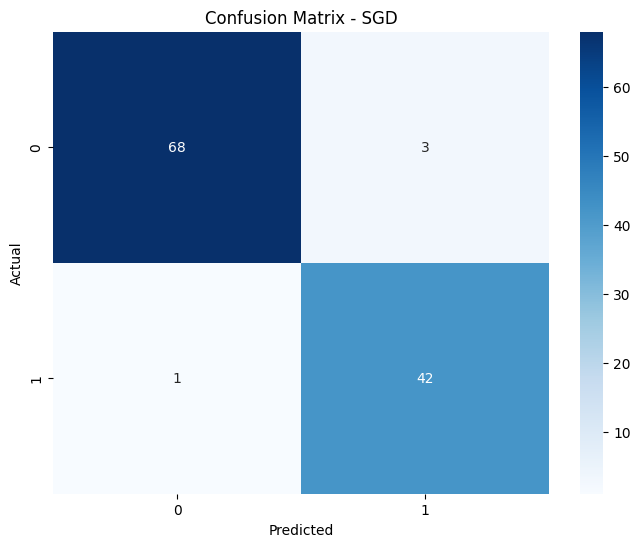

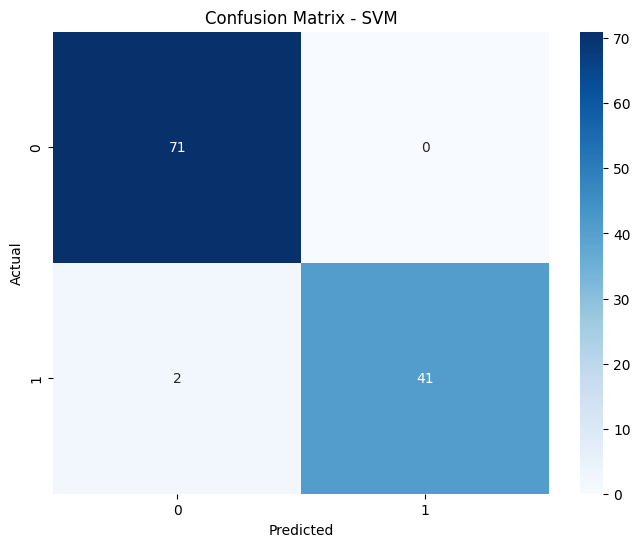

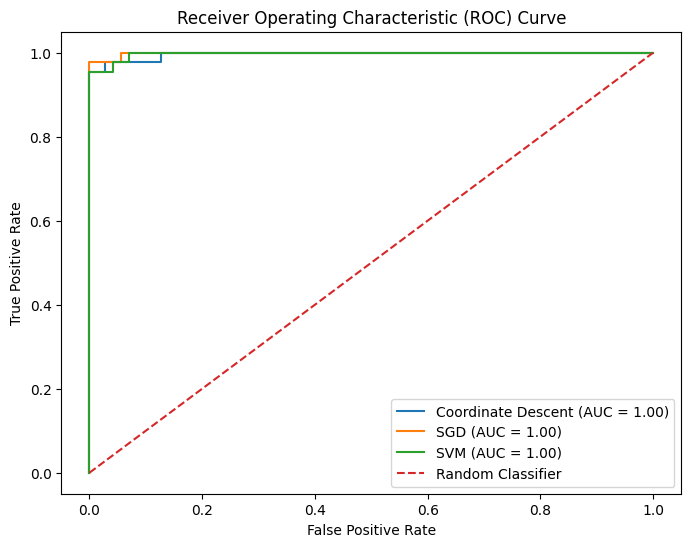


SVM Best Parameters:
{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}


In [2]:
# Import necessary libraries
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.svm import SVC

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

# Function to plot ROC curve
def plot_roc_curve(X, y, models):
    plt.figure(figsize=(8, 6))
    for name, model in models.items():
        if name in ['Coordinate Descent', 'SGD']:
            y_pred = sigmoid(X.dot(model))
        else:
            y_pred = model.predict_proba(X)[:, 1]
        fpr, tpr, _ = roc_curve(y, y_pred)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc(fpr, tpr):.2f})')

    plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

# Function to load and preprocess data
def load_data(url):
    # Load data without headers
    data = pd.read_csv(url, header=None)

    # Assign column names
    column_names = ['id', 'diagnosis'] + [f'feature_{i}' for i in range(1, 31)]
    data.columns = column_names

    # Separate features and target
    X = data.drop(['id', 'diagnosis'], axis=1)
    y = (data['diagnosis'] == 'M').astype(int)

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test

# Sigmoid function for logistic regression
def sigmoid(z):
    mask = z >= 0
    positive = np.zeros_like(z)
    negative = np.zeros_like(z)

    positive[mask] = 1 / (1 + np.exp(-z[mask]))
    negative[~mask] = np.exp(z[~mask]) / (1 + np.exp(z[~mask]))

    return positive + negative

# Logistic regression loss function
def log_loss(X, y, w):
    m = len(y)
    h = sigmoid(X.dot(w))
    # Add a small epsilon to avoid log(0)
    epsilon = 1e-15
    h = np.clip(h, epsilon, 1 - epsilon)
    return (-1/m) * (y.dot(np.log(h)) + (1-y).dot(np.log(1-h)))

# Coordinate Descent using the closed-form solution for logistic regression
def coordinate_descent_closed_form(X, y, max_iter=1000, tol=1e-6, alpha=0.01, selection='random'):
    m, n = X.shape
    w = np.zeros(n)  # Initialize weights to zero
    losses = []

    for iteration in range(max_iter):
        w_old = w.copy()

        if selection == 'cyclic':
            coordinate_order = range(n)  # Cycle through coordinates sequentially
        elif selection == 'random':
            coordinate_order = np.random.permutation(n)  # Randomly shuffle coordinates

        for j in coordinate_order:
            X_j = X[:, j]
            X_j_norm = np.linalg.norm(X_j) + 1e-10
            X_j = X_j / X_j_norm

            # Compute the residual
            residual = y - sigmoid(X @ w) + w[j] * X_j

            # Update the weight for feature j
            numerator = np.dot(X_j, residual)
            denominator = np.dot(X_j, X_j) + alpha
            if denominator > 0:
                w[j] = numerator / denominator

        # Compute log loss with regularization
        loss = log_loss(X, y, w) + 0.5 * alpha * np.sum(w**2)  # Regularization penalty
        losses.append(loss)

        # Check convergence
        if np.linalg.norm(w - w_old) < tol:
            print(f"CD converged after {iteration + 1} iterations")
            break

    return w, losses

# Stochastic Gradient Descent for logistic regression
def sgd(X, y, learning_rate=0.01, max_iter=1000, batch_size=32):
    m, n = X.shape
    w = np.zeros(n)
    losses = []
    tol=1e-2

    for iteration in range(max_iter):
        w_old = w.copy()
        indices = np.random.permutation(m)
        X_shuffled = X[indices]
        y_shuffled = y.iloc[indices].values if isinstance(y, pd.Series) else y[indices]

        for i in range(0, m, batch_size):
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]

            h = sigmoid(X_batch.dot(w))
            gradient = X_batch.T.dot(h - y_batch) / batch_size
            w -= learning_rate * gradient

        loss = log_loss(X, y, w)
        losses.append(loss)
        # Check convergence
        if np.linalg.norm(w - w_old) < tol:
            print(f"SGD converged after {iteration + 1} iterations")
            break

    return w, losses

# Function to evaluate model performance
def evaluate_model(X, y, w):
    y_pred = (sigmoid(X.dot(w)) >= 0.5).astype(int)
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    return accuracy, precision, recall, f1

# Main execution
if __name__ == "__main__":
    # Load and preprocess data
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data"
    X_train, X_test, y_train, y_test = load_data(url)
    X_train = X_train.values if isinstance(X_train, pd.DataFrame) else X_train
    y_train = y_train.values if isinstance(y_train, pd.Series) else y_train

    # Train models
    w_cd, losses_cd = coordinate_descent_closed_form(X_train, y_train, max_iter=5000, alpha=0.01, selection='random')
    w_sgd, losses_sgd = sgd(X_train, y_train)

    # SVM implementation
    svm_model = SVC(random_state=42, probability=True)
    svm_param_grid = {
        'C': [0.1, 1, 10],
        'kernel': ['rbf', 'linear'],
        'gamma': ['scale', 'auto', 0.1, 1]
    }
    svm_grid_search = GridSearchCV(svm_model, svm_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    svm_grid_search.fit(X_train, y_train)

    svm_best_model = svm_grid_search.best_estimator_
    svm_y_pred = svm_best_model.predict(X_test)

    # Evaluate models
    models = {
        'Coordinate Descent': w_cd,
        'SGD': w_sgd,
        'SVM': svm_best_model
    }

    # Output metrics
    for name, model in models.items():
        if name in ['Coordinate Descent', 'SGD']:
            metrics = evaluate_model(X_test, y_test, model)
        else:
            y_pred = model.predict(X_test)
            metrics = (
                accuracy_score(y_test, y_pred),
                precision_score(y_test, y_pred),
                recall_score(y_test, y_pred),
                f1_score(y_test, y_pred)
            )
        print(f"\n{name} Results:")
        print(f"Accuracy: {metrics[0]:.4f}, Precision: {metrics[1]:.4f}, Recall: {metrics[2]:.4f}, F1: {metrics[3]:.4f}")

    # Plot learning curves
    plt.figure(figsize=(10, 5))
    plt.plot(losses_cd, label='Coordinate Descent')
    plt.plot(losses_sgd, label='SGD')
    plt.xlabel('Iterations')
    plt.ylabel('Log Loss')
    plt.title('Learning Curves')
    plt.legend()
    plt.show()

    # Plot confusion matrices
    for name, model in models.items():
        if name in ['Coordinate Descent', 'SGD']:
            y_pred = (sigmoid(X_test.dot(model)) >= 0.5).astype(int)
        else:
            y_pred = model.predict(X_test)
        plot_confusion_matrix(y_test, y_pred, f'Confusion Matrix - {name}')

    # Plot ROC curves
    plot_roc_curve(X_test, y_test, models)

    # Output SVM Best Parameters
    print("\nSVM Best Parameters:")
    print(svm_grid_search.best_params_)